# Import Libraries

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.metrics import mean_squared_error

import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

In [18]:
plt.style.use('default')

plt.rcParams['figure.figsize'] = (16, 4)

custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Download dataset

In [19]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import dataset

In [20]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


In [21]:
df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER','PARI_RACING_TURNOVER']].sum(axis=1)
df['SPORT_TURNOVER'] = df[['FOB_SPORT_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)

cols = ['DATE_DIM', 'BET_ACCOUNT_NUM_HASH', 'TENURE_IN_DAYS', 'RACING_TURNOVER', 'SPORT_TURNOVER', 'TOTAL_TURNOVER']

In [22]:
df = df[cols]
df = df[df['DATE_DIM'] >= '2021-01-04']

In [23]:
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# Aggregate

In [6]:
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

df_agg = df.set_index('DATE_DIM').resample('d')[['RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].sum()

df_agg_2021 =  df_agg[df_agg.index.year == 2021]
df_agg_2022 =  df_agg[df_agg.index.year == 2022]

df_agg_2021.head()

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
DATE_DIM,,,,,,,,
2021-01-01,3675463.56,160299.45,1900648.00,1935115.01,3835763.01,3114833.37,612209.61,488315
2021-01-02,5908319.48,257615.55,3587422.50,2578512.53,6165935.03,4950862.44,1108761.73,698352
2021-01-03,1866557.48,331455.71,1262085.50,935927.69,2198013.19,1827063.93,329115.26,280743
2021-01-04,1201730.24,321881.93,908515.00,615097.17,1523612.17,1287379.59,199829.33,194844
2021-01-05,1255772.61,225060.21,827286.50,653546.32,1480832.82,1213781.16,251753.98,201685


Text(0.5, 1.0, '2021 TURNOVER')

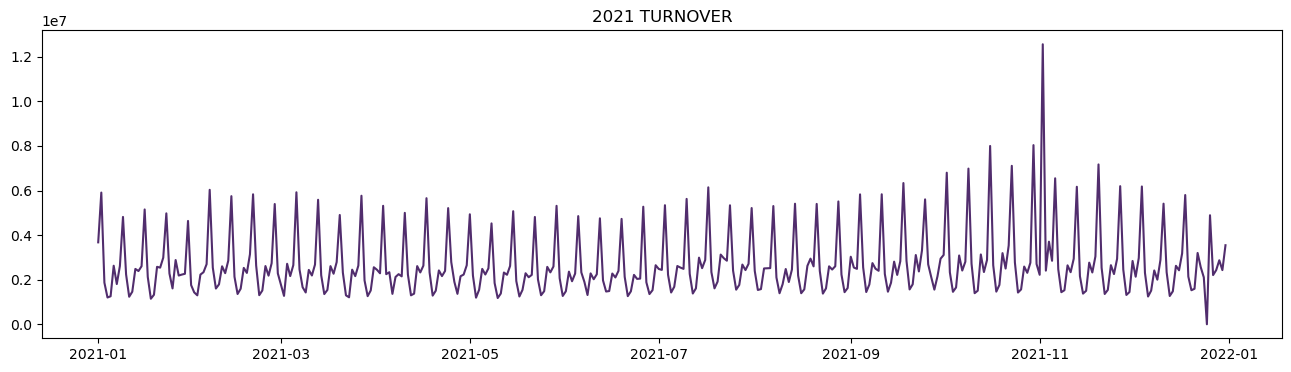

In [7]:
fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_agg_2021['RACING_TURNOVER'])
ax.set_title('2021 TURNOVER')

# RACING vs SPORT

In [8]:
X_racing = df_agg_2021['RACING_TURNOVER']
X_sport = df_agg_2021['SPORT_TURNOVER']

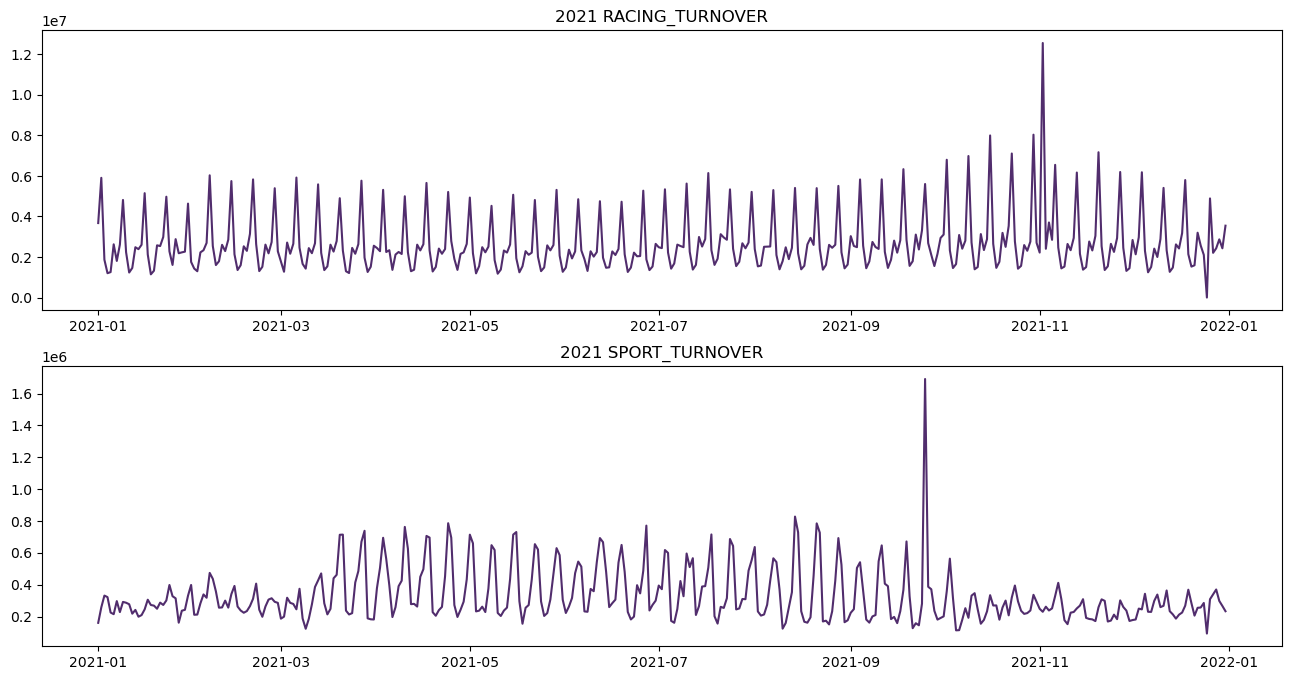

In [10]:

fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['RACING_TURNOVER'])
ax[0].set_title('2021 RACING_TURNOVER')

ax[1].plot(df_agg_2021['SPORT_TURNOVER'])
ax[1].set_title('2021 SPORT_TURNOVER')

plt.show()

In [11]:
X_racing = df_agg_2021['RACING_TURNOVER']
X_sport = df_agg_2021['SPORT_TURNOVER']

# Racing

In [12]:
offset=30
MSE_list = []

for index in range(30,336):
    X_train = X_racing[:index]
    X_test = X_racing[index:index+offset]
    
    exp_smth = ETSModel(X_train, seasonal_periods=7, trend = "add", seasonal = "mul")
    result = exp_smth.fit()

    start = X_train.index[-1] + pd.DateOffset(1)
    end = X_train.index[-1] + pd.DateOffset(offset)

    X_forecast = result.predict(start=start, end=end)
    
    diff = X_test - X_forecast
    MSE = np.linalg.norm(diff)/offset
    
    MSE_list.append(MSE)
    
MSE_list

[74086.60979869899,
 75830.64610814107,
 76013.94212158816,
 74265.49441136768,
 75157.28078014294,
 81728.64764425438,
 82571.78889812362,
 44484.54251734572,
 42702.93638272742,
 44571.88247022683,
 48535.846419500274,
 50550.49961409172,
 53875.612430031455,
 59820.90389342746,
 62847.435479955,
 62093.50727784419,
 61638.359236087366,
 59641.660678774235,
 58729.66068777596,
 74700.22123418331,
 82686.16838169337,
 83028.40445996486,
 91000.68793340036,
 89989.2855194494,
 86862.93272077416,
 87309.9937947943,
 86347.03425597514,
 87153.34705382165,
 77710.39346406459,
 77526.30208129107,
 80697.07162499735,
 72665.38376218844,
 76549.10260803408,
 76090.94920759762,
 73507.20083163632,
 78272.3566536668,
 80765.16538039307,
 86530.79969163671,
 81949.92773753329,
 81122.09008926789,
 86219.31535082009,
 84472.33091208189,
 77758.35421516714,
 75800.1430560601,
 73094.61565101006,
 70952.7406833098,
 70897.37359743791,
 70170.89942819587,
 70819.78633086088,
 54240.496493701634,
 5

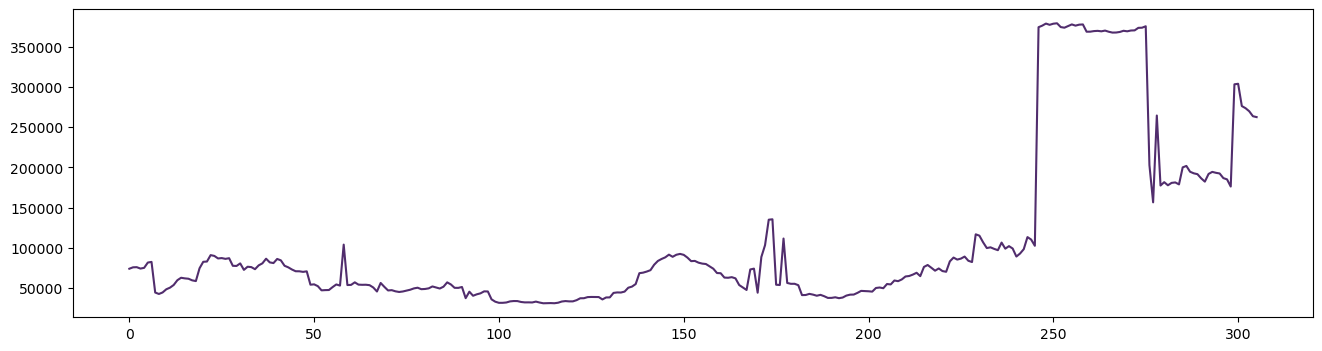

In [13]:
plt.plot(MSE_list)

In [14]:
offset=30
index=120

X_train = X_racing[:index]
X_test = X_racing[index:index+offset]

exp_smth = ETSModel(X_train, seasonal_periods=7, trend = "add", seasonal = "mul")
result = exp_smth.fit()

start = X_train.index[-1] + pd.DateOffset(1)
end = X_train.index[-1] + pd.DateOffset(offset)

X_forecast = result.predict(start=start, end=end)

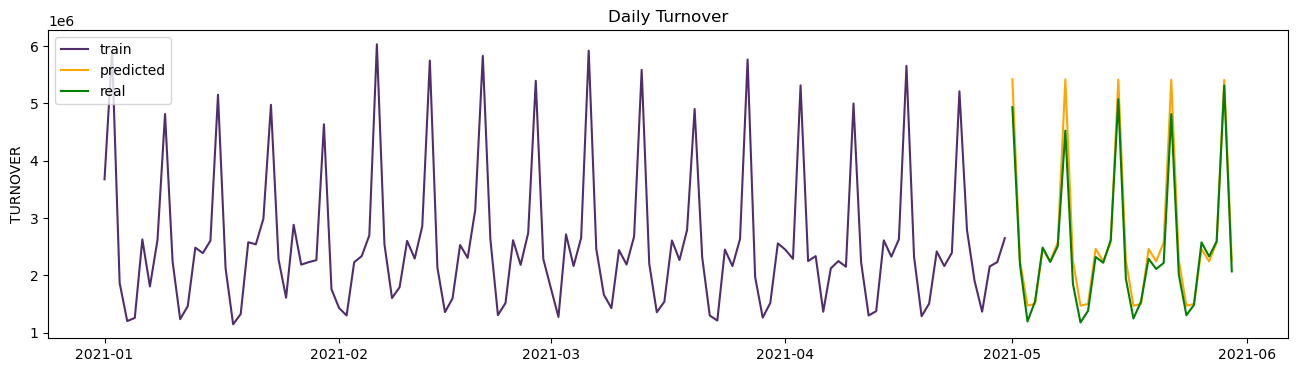

In [18]:
plt.figure(figsize=(16,4))

plt.plot(X_train)
plt.plot(X_forecast, c='orange')
plt.plot(X_test, c='green')
plt.ylabel("TURNOVER")
plt.title("Daily Turnover")
plt.legend(['train', 'predicted', 'real'], loc = 'upper left')

plt.show()

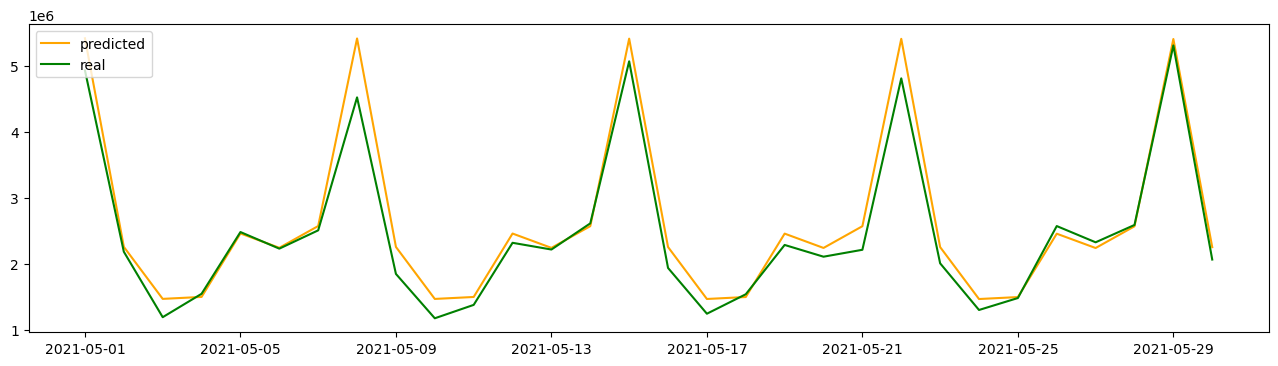

In [16]:
plt.figure(figsize=(16,4))

plt.plot(X_forecast, c='orange')
plt.plot(X_test, c='green', label='real')
plt.legend(['predicted', 'real'], loc = 'upper left')

plt.show()

# Individual

26755.359999999997
15304.372374277104


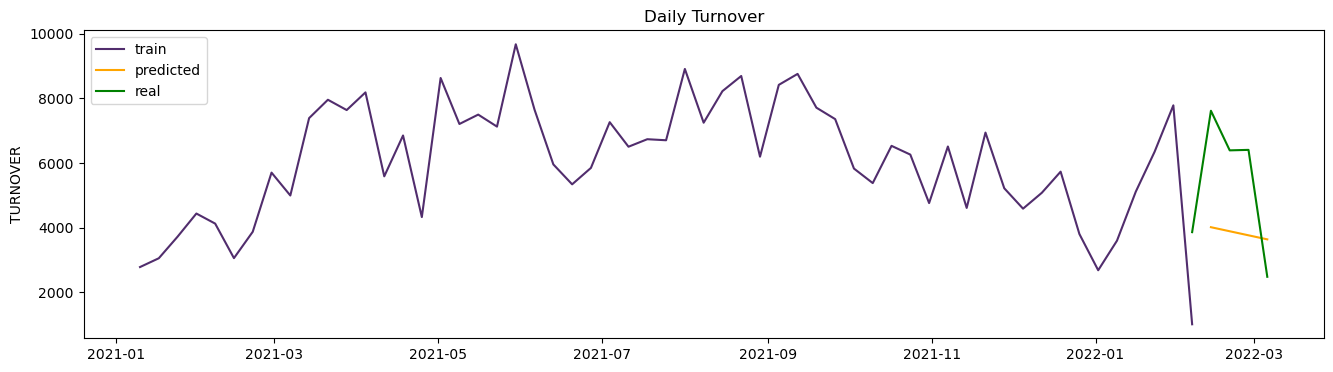

In [24]:
df_3636408132 = df.loc[df['BET_ACCOUNT_NUM_HASH'] == 3636408132, ['DATE_DIM','TOTAL_TURNOVER']]

offset=87+28*11

X_train = df_3636408132[:offset].set_index('DATE_DIM').resample('W').TOTAL_TURNOVER.sum().squeeze()
X_test = df_3636408132[offset:offset+28].set_index('DATE_DIM').resample('W').TOTAL_TURNOVER.sum().squeeze()

exp_smth = ETSModel(X_train, trend = "add", freq='W')

result = exp_smth.fit()

start = X_train.index[-1] + pd.DateOffset(7)
end = X_train.index[-1] + pd.DateOffset(28)
X_forecast = result.predict(start=start, end=end)

print(sum(X_test))
print(sum(X_forecast))


plt.figure(figsize=(16,4))

plt.plot(X_train)
plt.plot(X_forecast, c='orange')
plt.plot(X_test, c='green')
plt.ylabel("TURNOVER")
plt.title("Daily Turnover")
plt.legend(['train', 'predicted', 'real'], loc = 'upper left')

plt.show()

In [26]:
def exponential_smoothing(df, week_offset=3, last_days=last_days):

SyntaxError: incomplete input (1792203464.py, line 1)

In [199]:
start_date = '2021-01-04'
end_date = '2031-12-22'

date_range = pd.date_range(start=start_date, end=end_date)
last_days = date_range.to_frame().resample('W').first().index

week_offset=8

last_day = last_days[week_offset]

train_df = df[df['DATE_DIM'] <= last_days[week_offset]]
test_df = df[(df['DATE_DIM'] > last_days[week_offset]) & (df['DATE_DIM'] <= last_days[week_offset+4])]

cus = train_df.groupby('BET_ACCOUNT_NUM_HASH',as_index=False).TENURE_IN_DAYS.max()
cus = cus.loc[cus['TENURE_IN_DAYS'] >28, 'BET_ACCOUNT_NUM_HASH']

train_df = train_df[train_df['BET_ACCOUNT_NUM_HASH'].isin(cus)]
test_df = test_df[test_df['BET_ACCOUNT_NUM_HASH'].isin(cus)]

In [202]:
start = last_days[week_offset] + pd.DateOffset(7)
end = last_days[week_offset] + pd.DateOffset(28)

res = res = pd.DataFrame(columns = ['BET_ACCOUNT_NUM_HASH', 'real', 'pred'])
X_test = test_df.groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum()

for i in cus:
    cus_df = train_df[train_df['BET_ACCOUNT_NUM_HASH'] == i]
    
    X_train = cus_df.set_index('DATE_DIM').resample('W').TOTAL_TURNOVER.sum()
    X_train = X_train.reindex(last_days[:week_offset+4]).fillna(0)
    
    exp_smth = ETSModel(X_train, trend = "add", freq='W')
    
    result = exp_smth.fit()

    X_forecast = result.predict(start=start, end=end)
    
    try:
        real = X_test[i]
    except:
        real = 0
    
    pred = X_forecast.sum()
    
    res = res.append({'BET_ACCOUNT_NUM_HASH' : i, 'real':real, 'pred' pred}, ignore_index=True)

In [203]:
res['fixed_pred'] = res['pred'].apply(lambda x: 0 if x < 0 else x)

In [204]:
res

,BET_ACCOUNT_NUM_HASH,real,pred,fixed_pred
0,13154.00,20210.62,6820.68,6820.68
1,18379.00,1010.00,-89.14,0.00
2,406536.00,0.00,10.56,10.56
3,433164.00,379.50,286.22,286.22
4,559232.00,238.00,-98.85,0.00
...,...,...,...,...
59052,4294115274.00,0.00,6.42,6.42
59053,4294378139.00,146.00,82.94,82.94
59054,4294561160.00,70.00,6.61,6.61
59055,4294834703.00,6180.50,937.06,937.06


(-5000.0, 100000.0)

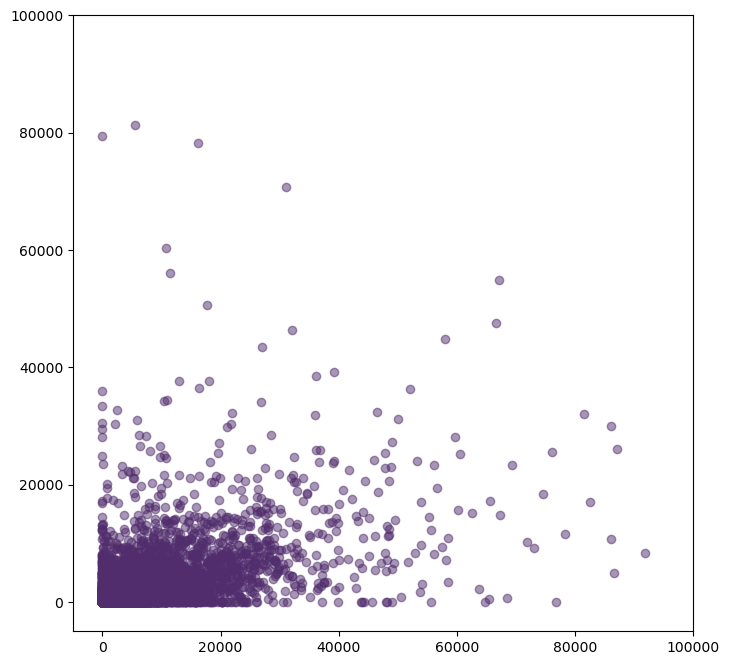

In [219]:
plt.figure(figsize=(8,8))
plt.scatter(res['real'], res['fixed_pred'], alpha=0.5)
plt.ylim((-5000,100000))
plt.xlim((-5000,100000))

In [222]:
mean_squared_error(res['real']/28 , res['fixed_pred']/28)

20180.97367915797

In [223]:
res[res['pred'] >= 80000]

,BET_ACCOUNT_NUM_HASH,real,pred,fixed_pred
3855,276859096.00,5451.00,81237.61,81237.61
7292,525598846.00,197457.00,88598.99,88598.99
14215,1025496080.00,543813.00,201636.84,201636.84
14948,1077839957.00,261168.00,105621.95,105621.95
21658,1562672387.00,270600.00,89565.63,89565.63
57620,4186967104.00,3786.00,115744.12,115744.12
